In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix)
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('../data/koi_cumulative.csv', comment='#')
print(f"Dataset shape: {df.shape}")
print(f"Class distribution:\n{df['koi_disposition'].value_counts()}")

Dataset shape: (9564, 49)
Class distribution:
koi_disposition
FALSE POSITIVE    4839
CONFIRMED         2746
CANDIDATE         1979
Name: count, dtype: int64


## Program 4: Decision Tree Classifier — Exoplanet Vetting

**Scientific Background:**  
A Decision Tree mimics how a human astronomer might manually vet a planet candidate
— asking a series of yes/no questions about the signal's properties.

For example:
- Is the signal-to-noise ratio high enough? (koi_model_snr)
- Is the transit depth consistent with a planet-sized object? (koi_depth)
- Is the impact parameter physically reasonable? (koi_impact)

Unlike Logistic Regression, Decision Trees are fully **interpretable** —
we can visualize exactly which rules the model learned and in what order.

**Key advantage for this paper:** We can see *which Kepler features matter most*
for separating real planets from false positives — this has direct astrophysical meaning.

In [2]:
# Binary classification: CONFIRMED vs FALSE POSITIVE
data = df[df['koi_disposition'].isin(['CONFIRMED', 'FALSE POSITIVE'])].copy()
data['label'] = (data['koi_disposition'] == 'CONFIRMED').astype(int)

features = ['koi_period', 'koi_impact', 'koi_duration', 'koi_depth',
            'koi_model_snr', 'koi_steff', 'koi_slogg', 'koi_srad',
            'koi_prad', 'koi_teq']

data = data[features + ['label']].dropna()
print(f"Usable rows: {len(data)}")
print(f"CONFIRMED: {sum(data['label']==1)} | FALSE POSITIVE: {sum(data['label']==0)}")

X = data[features].values
y = data['label'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

Usable rows: 7326
CONFIRMED: 2744 | FALSE POSITIVE: 4582


In [3]:
# Train Decision Tree
model = DecisionTreeClassifier(
    max_depth=5,           # Limit depth for interpretability
    min_samples_split=20,
    class_weight='balanced',
    random_state=42
)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

acc = accuracy_score(y_test, y_pred)

print("=" * 50)
print("       DECISION TREE RESULTS")
print("=" * 50)
print(f"  Max Depth  : {model.get_depth()}")
print(f"  Num Leaves : {model.get_n_leaves()}")
print(f"  Accuracy   : {acc:.4f} ({acc*100:.2f}%)")
print("=" * 50)
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred,
      target_names=['FALSE POSITIVE', 'CONFIRMED']))

# Text representation of top rules
print("\nTop Decision Rules:")
print(export_text(model, feature_names=features, max_depth=3))

       DECISION TREE RESULTS
  Max Depth  : 5
  Num Leaves : 27
  Accuracy   : 0.8759 (87.59%)

Classification Report:
                precision    recall  f1-score   support

FALSE POSITIVE       0.95      0.84      0.89       917
     CONFIRMED       0.78      0.93      0.85       549

      accuracy                           0.88      1466
     macro avg       0.87      0.89      0.87      1466
  weighted avg       0.89      0.88      0.88      1466


Top Decision Rules:
|--- koi_prad <= 13.49
|   |--- koi_model_snr <= 12.55
|   |   |--- koi_model_snr <= 11.25
|   |   |   |--- koi_period <= 35.78
|   |   |   |   |--- truncated branch of depth 2
|   |   |   |--- koi_period >  35.78
|   |   |   |   |--- truncated branch of depth 2
|   |   |--- koi_model_snr >  11.25
|   |   |   |--- koi_period <= 160.80
|   |   |   |   |--- truncated branch of depth 2
|   |   |   |--- koi_period >  160.80
|   |   |   |   |--- truncated branch of depth 2
|   |--- koi_model_snr >  12.55
|   |   |--- koi

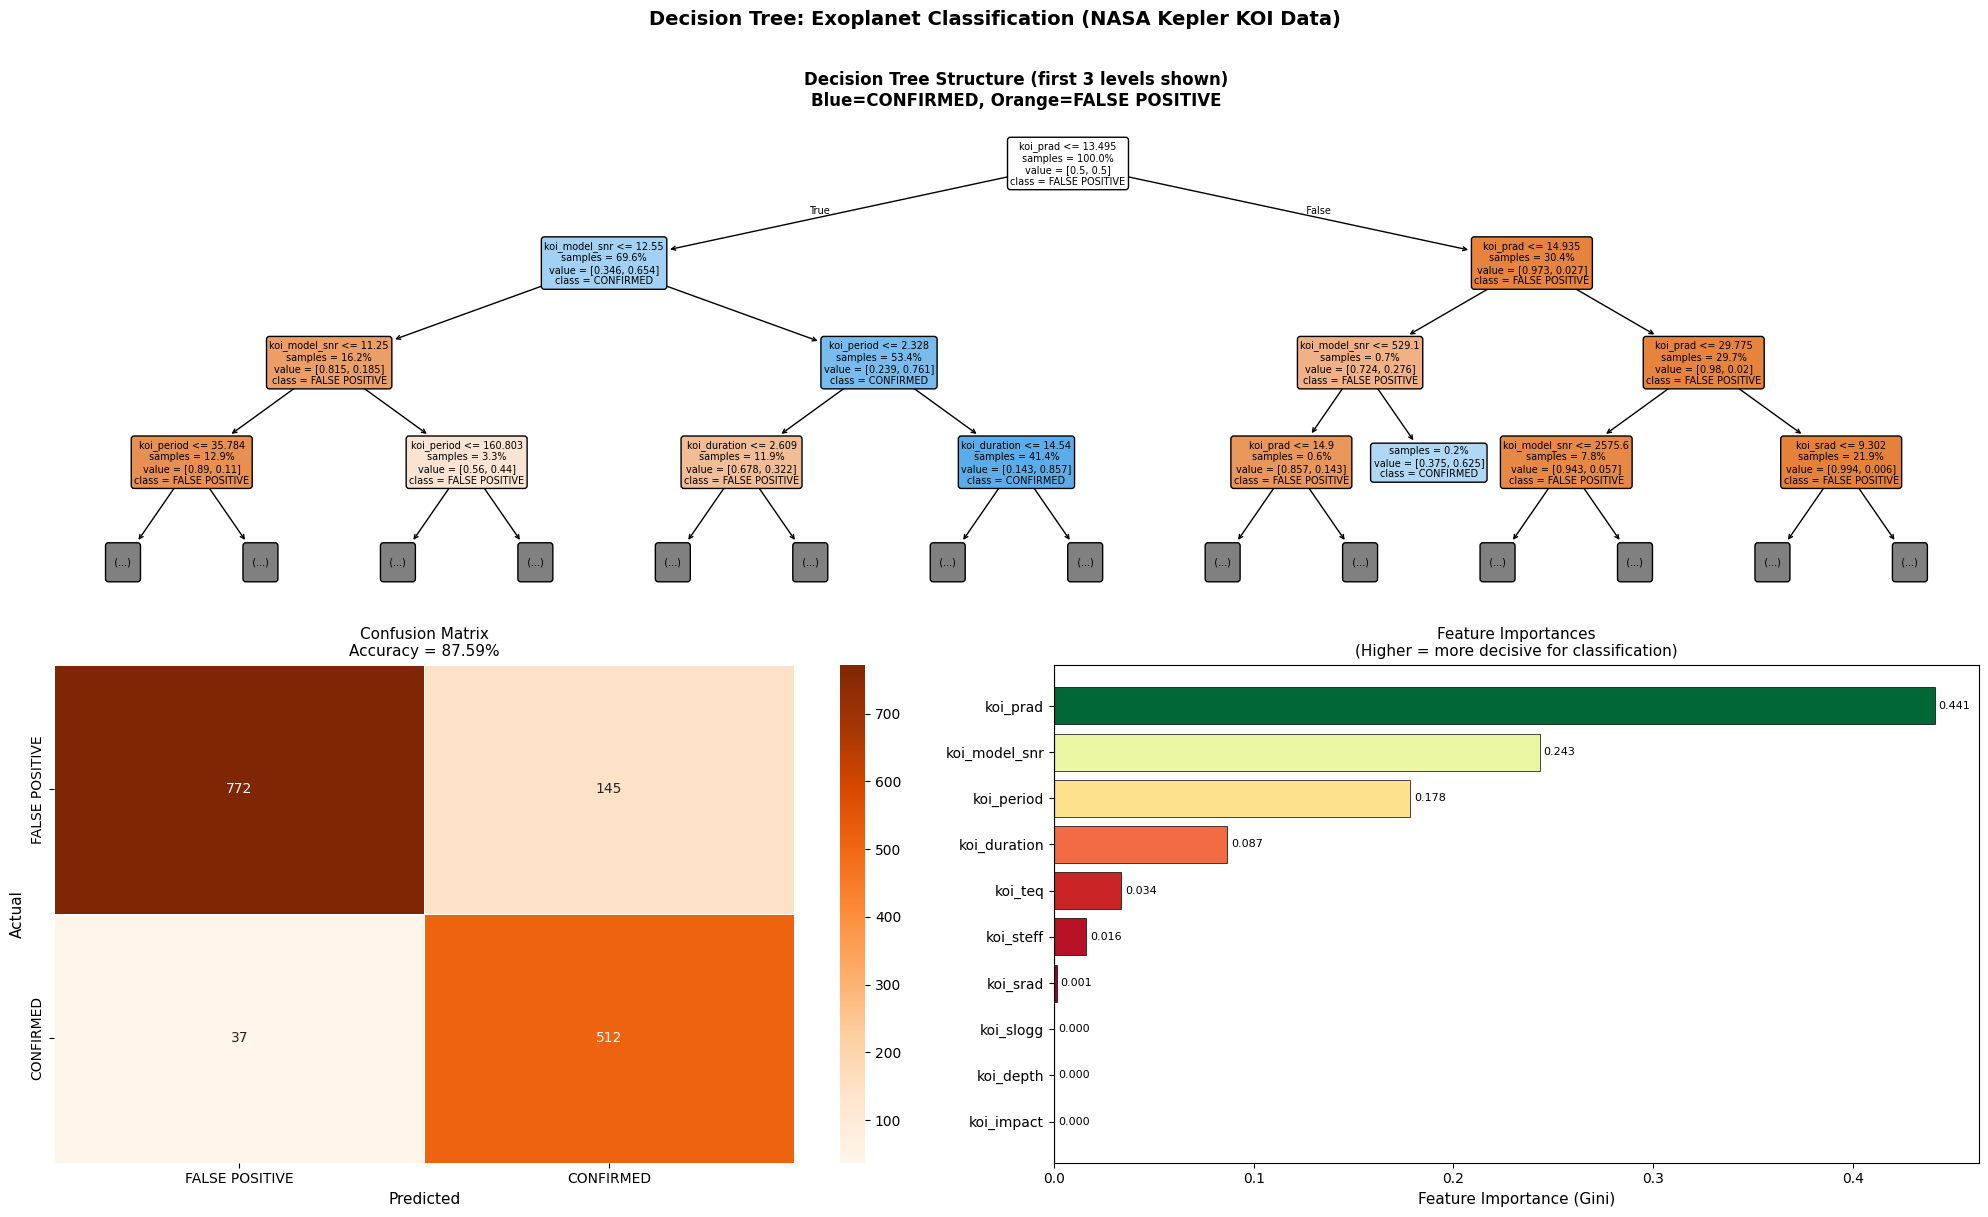

Plot saved!


In [4]:
fig = plt.figure(figsize=(20, 12))

# Plot 1: The Decision Tree itself (top portion)
ax1 = fig.add_subplot(2, 2, (1, 2))
plot_tree(model, feature_names=features,
          class_names=['FALSE POSITIVE', 'CONFIRMED'],
          filled=True, rounded=True, fontsize=7,
          max_depth=3, ax=ax1,
          impurity=False, proportion=True)
ax1.set_title('Decision Tree Structure (first 3 levels shown)\nBlue=CONFIRMED, Orange=FALSE POSITIVE',
              fontsize=12, fontweight='bold')

# Plot 2: Confusion Matrix
ax2 = fig.add_subplot(2, 2, 3)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', ax=ax2,
            xticklabels=['FALSE POSITIVE', 'CONFIRMED'],
            yticklabels=['FALSE POSITIVE', 'CONFIRMED'],
            linewidths=0.5)
ax2.set_xlabel('Predicted', fontsize=11)
ax2.set_ylabel('Actual', fontsize=11)
ax2.set_title(f'Confusion Matrix\nAccuracy = {acc*100:.2f}%', fontsize=11)

# Plot 3: Feature Importances
ax3 = fig.add_subplot(2, 2, 4)
importances = model.feature_importances_
sorted_idx = np.argsort(importances)
colors = plt.cm.RdYlGn(importances[sorted_idx] / importances.max())
bars = ax3.barh([features[i] for i in sorted_idx], importances[sorted_idx],
                color=colors, edgecolor='black', linewidth=0.5)
ax3.set_xlabel('Feature Importance (Gini)', fontsize=11)
ax3.set_title('Feature Importances\n(Higher = more decisive for classification)', fontsize=11)
ax3.axvline(0, color='black', lw=0.8)
for bar, imp in zip(bars, importances[sorted_idx]):
    ax3.text(bar.get_width() + 0.002, bar.get_y() + bar.get_height()/2,
             f'{imp:.3f}', va='center', fontsize=8)

fig.suptitle('Decision Tree: Exoplanet Classification (NASA Kepler KOI Data)',
             fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig('../outputs/plots/04_decision_tree.png', dpi=150, bbox_inches='tight')
plt.show()
print("Plot saved!")

In [6]:
# Top 3 most important features
top3_idx = np.argsort(model.feature_importances_)[::-1][:3]

print("Decision Tree: Scientific Interpretation")
print("=" * 55)
print(f"""
The Decision Tree learned a set of explicit IF-THEN rules
to separate real exoplanets from false positives.

Model Stats:
  • Tree depth    : {model.get_depth()} levels
  • Leaf nodes    : {model.get_n_leaves()} decision endpoints
  • Accuracy      : {acc*100:.2f}%

Top 3 most important features:
  1. {features[top3_idx[0]]:15s} → importance: {model.feature_importances_[top3_idx[0]]:.4f}
  2. {features[top3_idx[1]]:15s} → importance: {model.feature_importances_[top3_idx[1]]:.4f}
  3. {features[top3_idx[2]]:15s} → importance: {model.feature_importances_[top3_idx[2]]:.4f}

Astrophysical meaning:
  • koi_model_snr : High SNR transits are more likely real planets
  • koi_prad      : Planet radius separates giants (often FP) from small planets
  • koi_depth     : Transit depth relates to the planet-to-star radius ratio

The tree structure mirrors how human astronomers manually
vet planet candidates — validating the model's logic.
""")

Decision Tree: Scientific Interpretation

The Decision Tree learned a set of explicit IF-THEN rules
to separate real exoplanets from false positives.

Model Stats:
  • Tree depth    : 5 levels
  • Leaf nodes    : 27 decision endpoints
  • Accuracy      : 87.59%

Top 3 most important features:
  1. koi_prad        → importance: 0.4409
  2. koi_model_snr   → importance: 0.2431
  3. koi_period      → importance: 0.1782

Astrophysical meaning:
  • koi_model_snr : High SNR transits are more likely real planets
  • koi_prad      : Planet radius separates giants (often FP) from small planets
  • koi_depth     : Transit depth relates to the planet-to-star radius ratio

The tree structure mirrors how human astronomers manually
vet planet candidates — validating the model's logic.

